# **STEP 1 — Import Libraries**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects
from sklearn.metrics import confusion_matrix

# **STEP 2 — Define Paths**

In [2]:
base_path = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE"
train_images_path = os.path.join(base_path, "training", "images")
train_gt_path = os.path.join(base_path, "training", "1st_manual")
train_mask_path = os.path.join(base_path, "training", "mask")

print(os.listdir(train_images_path)[:5])

['34_training.tif', '40_training.tif', '22_training.tif', '27_training.tif', '28_training.tif']


# **STEP 3 — Load One Image**

In [3]:
img_name = "21_training.tif"
gt_name = "21_manual1.gif"
mask_name = "21_training_mask.gif"

# Load image
image = cv2.imread(os.path.join(train_images_path, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract green channel
green = image[:, :, 1] / 255.0

# Load ground truth
gt = cv2.imread(os.path.join(train_gt_path, gt_name), 0)
gt = gt > 0

# Load FOV mask
fov = cv2.imread(os.path.join(train_mask_path, mask_name), 0)
fov = fov > 0

print("Image loaded successfully ")

Image loaded successfully 


# **Step 4 - Apply Niblack & Sauvola**

In [4]:
window_size = 25

# Niblack
thresh_n = threshold_niblack(green, window_size=window_size, k=-0.2)
binary_n = green < thresh_n

# Sauvola
thresh_s = threshold_sauvola(green, window_size=window_size, k=0.3)
binary_s = green < thresh_s

# **Step 5 - Remove Small Noise**

In [5]:
binary_n = remove_small_objects(binary_n, min_size=50)
binary_s = remove_small_objects(binary_s, min_size=50)

# **Step 6 - Apply FOV Mask**

In [6]:
binary_n = binary_n & fov
binary_s = binary_s & fov

# **Step 7 - Compute Sensitivity**

In [7]:
def sensitivity(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()
    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    return tp / (tp + fn)

sens_n = sensitivity(binary_n, gt)
sens_s = sensitivity(binary_s, gt)

print("Sensitivity - Niblack :", sens_n)
print("Sensitivity - Sauvola :", sens_s)

Sensitivity - Niblack : 0.9145916132695271
Sensitivity - Sauvola : 0.012166436856192717


# **Step 8 - Visualize Results**

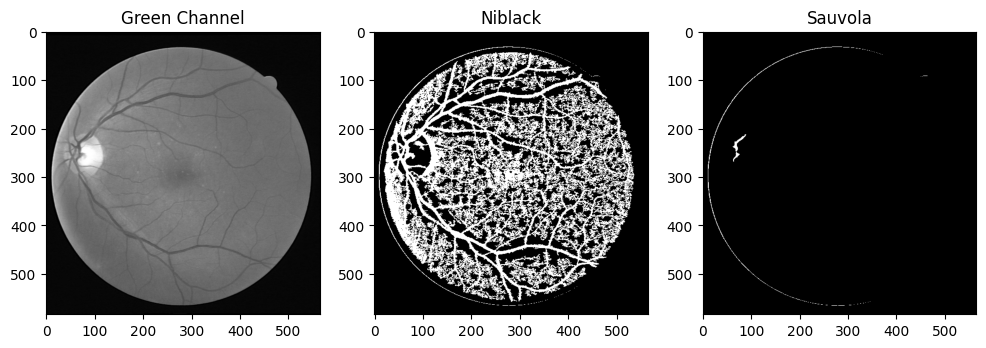

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title("Green Channel")
plt.imshow(green, cmap='gray')

plt.subplot(1,3,2)
plt.title("Niblack")
plt.imshow(binary_n, cmap='gray')

plt.subplot(1,3,3)
plt.title("Sauvola")
plt.imshow(binary_s, cmap='gray')

plt.show()

# **Step 9 - Evaluate ALL Training Images (21–40)**

In [9]:
sens_n_list = []
sens_s_list = []

for i in range(21, 41):
    
    img_name = f"{i}_training.tif"
    gt_name = f"{i}_manual1.gif"
    mask_name = f"{i}_training_mask.gif"
    
    image = cv2.imread(os.path.join(train_images_path, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    green = image[:, :, 1] / 255.0
    
    gt = cv2.imread(os.path.join(train_gt_path, gt_name), 0) > 0
    fov = cv2.imread(os.path.join(train_mask_path, mask_name), 0) > 0
    
    # Niblack
    thresh_n = threshold_niblack(green, window_size=25, k=-0.2)
    bin_n = remove_small_objects(green < thresh_n, 50) & fov
    
    # Sauvola
    thresh_s = threshold_sauvola(green, window_size=25, k=0.3)
    bin_s = remove_small_objects(green < thresh_s, 50) & fov
    
    sens_n_list.append(sensitivity(bin_n, gt))
    sens_s_list.append(sensitivity(bin_s, gt))

print("Average Sensitivity Niblack:", np.mean(sens_n_list))
print("Average Sensitivity Sauvola:", np.mean(sens_s_list))

Average Sensitivity Niblack: 0.8963857923590893
Average Sensitivity Sauvola: 0.02264685859749321
